Plan: - use bagging to select sample from the training dataset used to train the following models
Adpated version of a custom CNN
Adapted version of AlexNet
Adapted Version of VGGNet (Visual Geometry Group Network)
Inception (GoogLeNet)
Yolo (You Only Look Once)

All models should be adapted such that they focus on the pcitures most similar to the iput image to predict coordinates. input iage should also be scaled to 512 by 512 for this model.

all of these should be similar to their original architectures, but whith changes layer sizes, added dropout layers, somthing modified notheless, the models should be cited though, the models shouldbe called model 1,2,3,4,5.

there should be different hyperparamters used, such as the number of epochs for each model, learning rate, batch size. Grid search for each model.

In te end, I want to build an ensebmble of these 5 trained networks, and assign weights to the predictions of each networks, such that the test loss is minimized. thus the weights should be learned. These weights should be hyperparametrs too.

# Imports and Packages

In [ ]:
!pip install geopy > delete.txt
!pip install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt
!huggingface-cli login

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add

In [ ]:
from datasets import load_dataset, Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import resample
from itertools import product
import torchvision.models as models

# Downloading the train and test Dataset

In [ ]:
dataset_train = load_dataset("CIS-5190-CIA/Training_images", split="train")
dataset_test = load_dataset("CIS-5190-CIA/Testing_images", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/365 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4469 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/361 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1916 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 4469
})
Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 1916
})


In [ ]:
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # normalize the latitude and longitude
        self.latitudes = np.array(hf_dataset['Latitude'])
        self.longitudes = np.array(hf_dataset['Longitude'])
        self.latitude_mean = lat_mean if lat_mean is not None else self.latitudes.mean()
        self.latitude_std = lat_std if lat_std is not None else self.latitudes.std()
        self.longitude_mean = lon_mean if lon_mean is not None else self.longitudes.mean()
        self.longitude_std = lon_std if lon_std is not None else self.longitudes.std()

        self.normalized_latitudes = (self.latitudes - self.latitude_mean) / self.latitude_std
        self.normalized_longitudes = (self.longitudes - self.longitude_mean) / self.longitude_std

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]['image']
        latitude = self.normalized_latitudes[idx]
        longitude = self.normalized_longitudes[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([latitude, longitude], dtype=torch.float)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

lat_mean, lat_std = train_dataset.latitude_mean, train_dataset.latitude_std
lon_mean, lon_std = train_dataset.longitude_mean, train_dataset.longitude_std

val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# testing the dataloader
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 2])


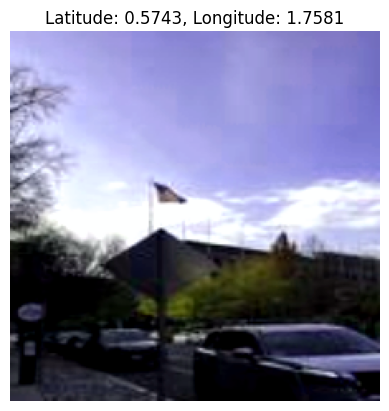

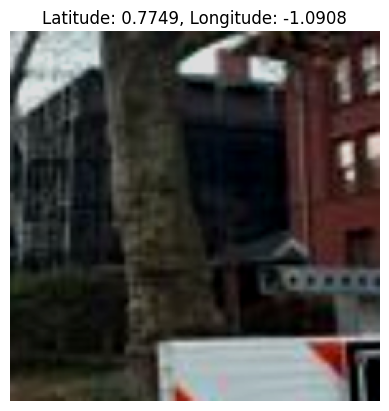

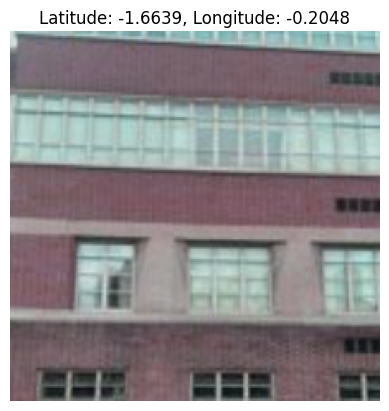

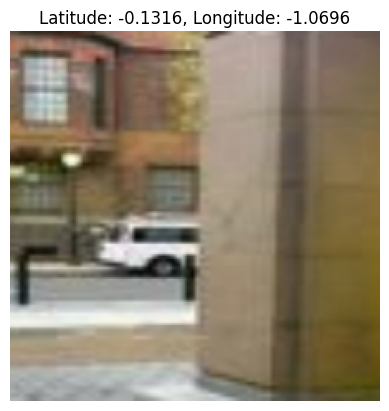

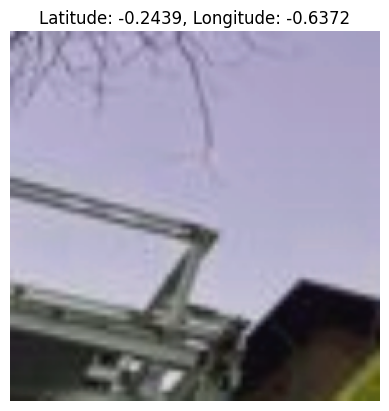

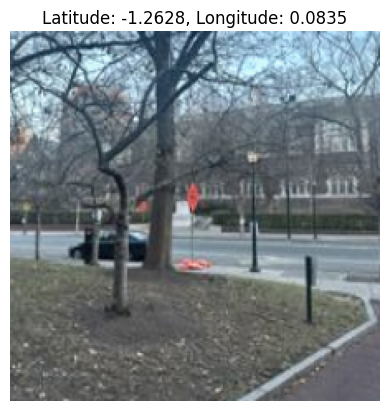

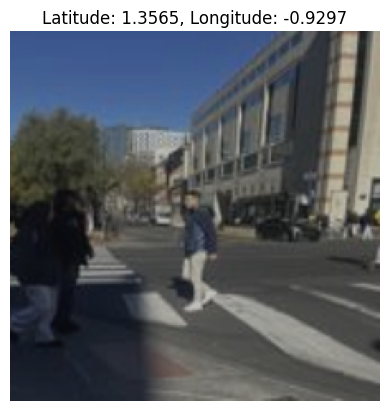

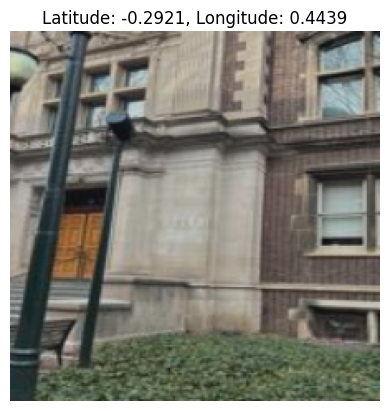

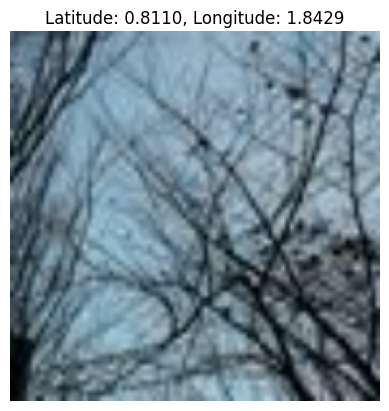

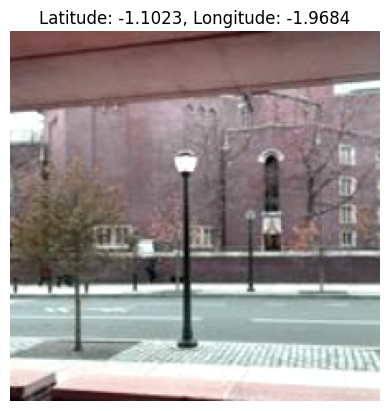

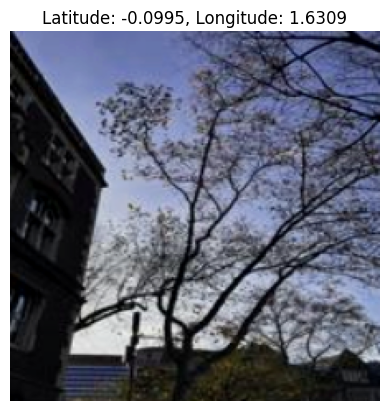

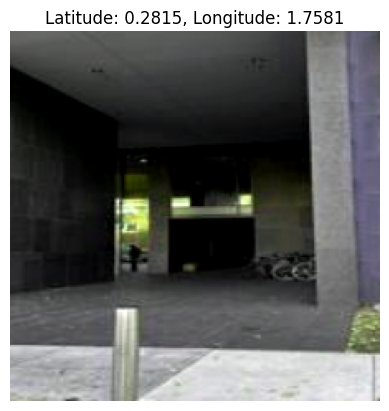

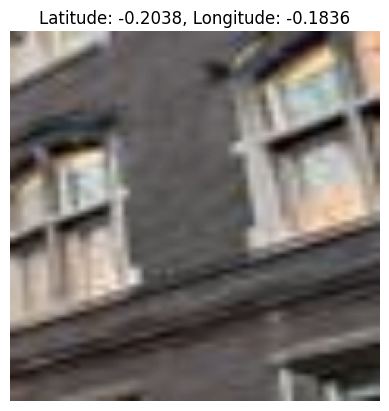

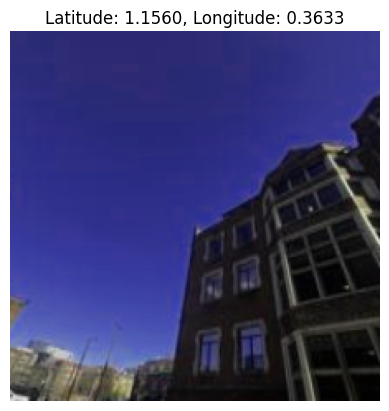

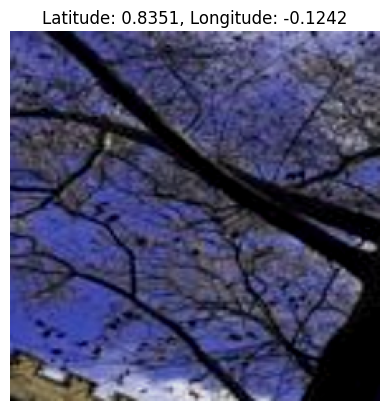

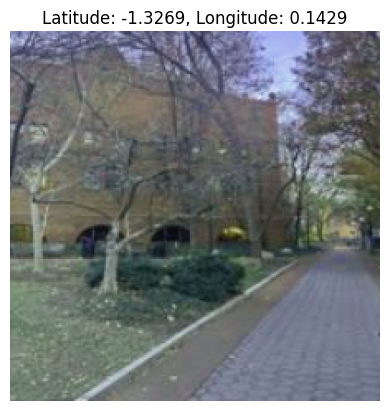

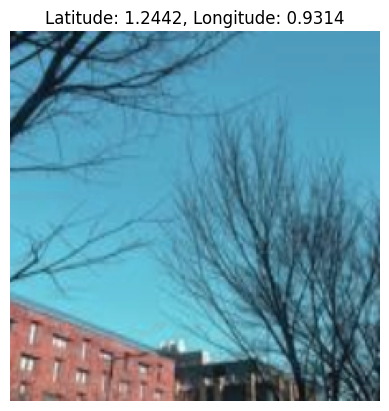

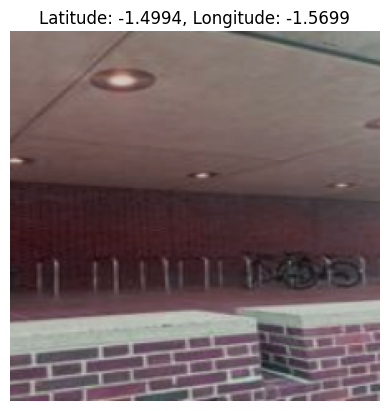

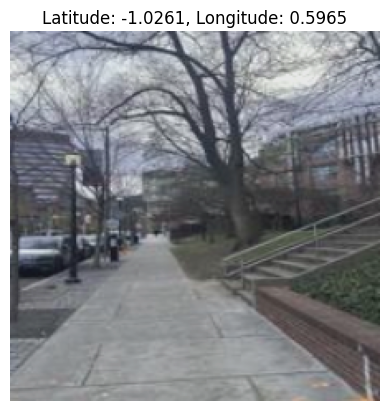

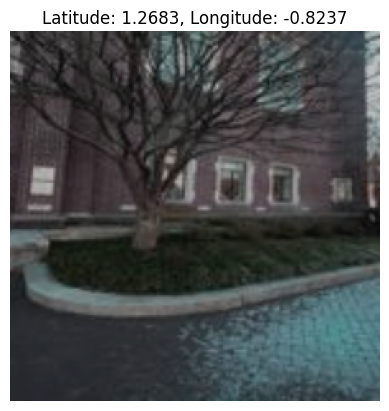

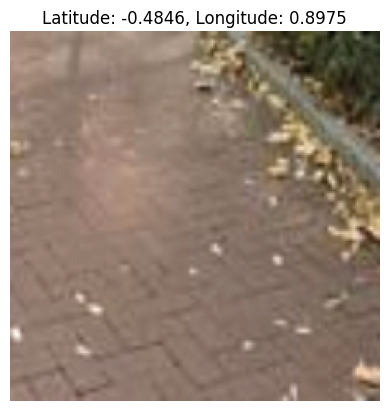

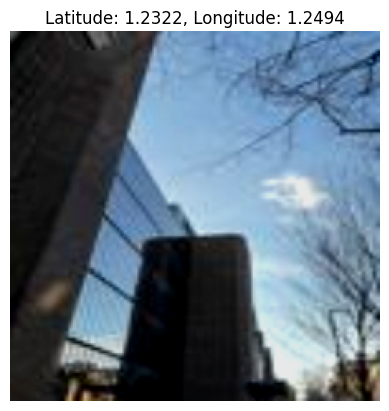

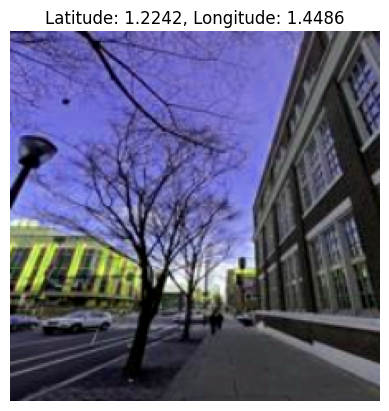

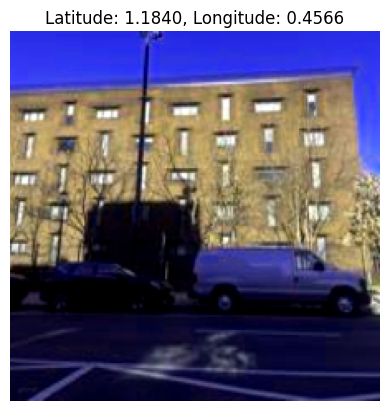

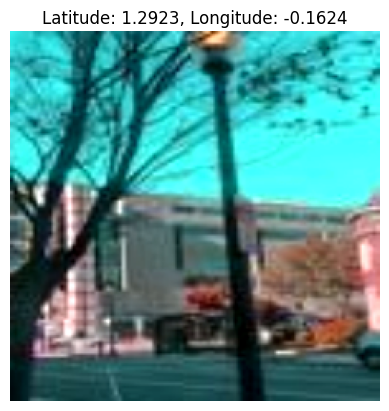

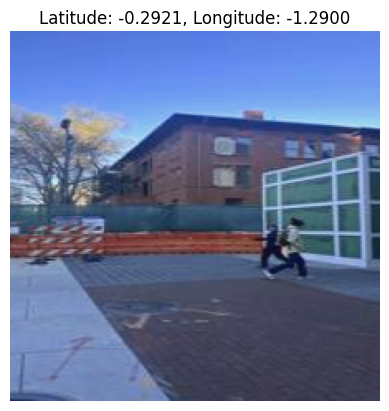

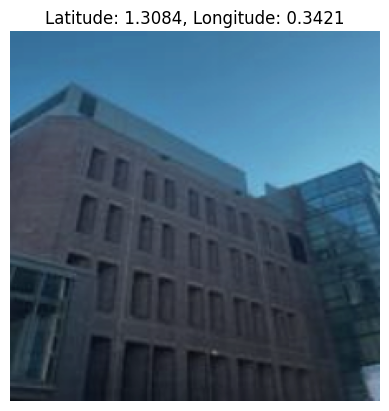

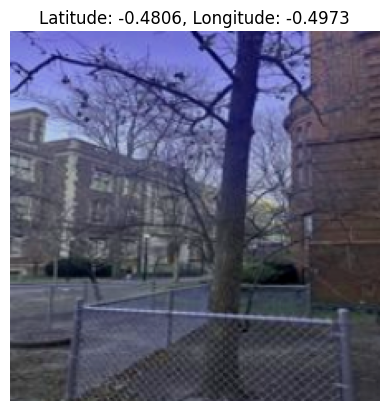

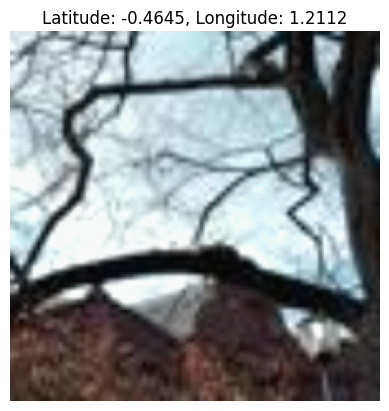

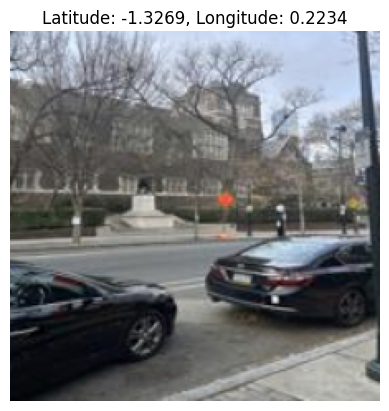

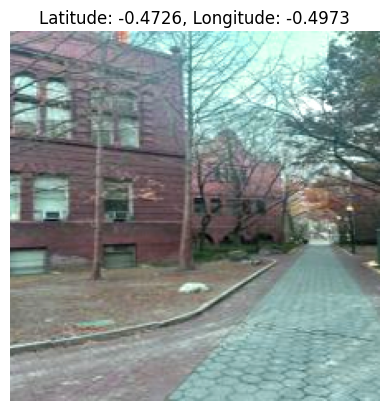

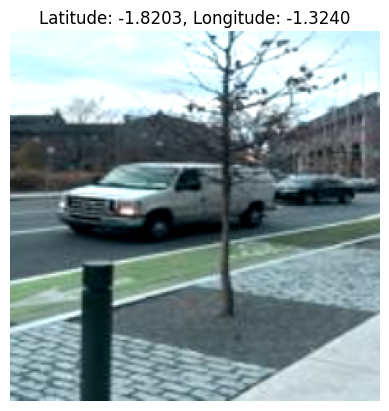

In [ ]:
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)

itr = 0
for im in images:
  image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  plt.imshow(image)
  plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
  plt.axis('off')
  plt.show()
  itr += 1

# Defining Models for Ensemble

Model 1

In [ ]:
class Model1(nn.Module):
    def __init__(self, dropout):
        super(Model1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def model_fn(dropout):
    return Model1(dropout)

Model 2

In [ ]:
class Model2(nn.Module):
    def __init__(self, num_blocks=3, dropout_rate=0.5):
        super(Model2, self).__init__()

        # Load ResNet blocks
        resnet = models.resnet34(pretrained=True)  # Start with ResNet34

        # Adapt ResNet: Freeze earlier layers if necessary
        for param in list(resnet.parameters())[:num_blocks]:
            param.requires_grad = False

        # Extract layers
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # All layers except FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Modify classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

Model 4

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()

        # 1x1 Convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3 Convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 5x5 Convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        # 3x3 Pooling -> 1x1 Convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        return outputs

class Model4(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Model4, self).__init__()

        # Initial layers
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception modules
        self.inception1 = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        # Pooling layer after inception modules
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Additional inception modules (if needed)
        self.inception3 = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4 = InceptionModule(512, 160, 112, 224, 24, 64, 64)

        # Global average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Training and testing

In [ ]:
def create_bagging_datasets(dataset, num_models=5):
    """
    Creates multiple datasets for bagging by sampling with replacement.
    """
    datasets = []
    for _ in range(num_models):
        indices = resample(range(len(dataset)), replace=True, n_samples=len(dataset))
        subset = torch.utils.data.Subset(dataset, indices)
        datasets.append(subset)
    return datasets

def grid_search(train_dataloader, val_dataloader, model_fn, param_grid, criterion, lat_mean, lon_mean, lat_std, lon_std):
    """
    Perform grid search to optimize hyperparameters for Model1.
    """
    results = []
    param_combinations = list(product(*param_grid.values()))
    for params in param_combinations:
        lr, dropout = params

        model = model_fn(dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_model_with_logging(
            model,
            train_dataloader,
            val_dataloader,
            criterion,
            optimizer,
            lat_mean,
            lon_mean,
            lat_std,
            lon_std,
            num_epochs=10
        )

        val_rmse = compute_validation_rmse(model, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)
        results.append((params, val_rmse))

    return sorted(results, key=lambda x: x[1])

def grid_search_model2(train_dataloader, val_dataloader, model_fn, param_grid, criterion, lat_mean, lon_mean, lat_std, lon_std):
    """
    Perform grid search to optimize hyperparameters for Model2.
    """
    results = []
    param_combinations = list(product(*param_grid.values()))

    for params in param_combinations:
        lr, dropout, num_blocks = params

        # Initialize Model2 with current parameters
        model = model_fn(num_blocks, dropout).to(device)

        # Set up optimizer with current learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model
        train_model_with_logging(
            model,
            train_dataloader,
            val_dataloader,
            criterion,
            optimizer,
            lat_mean,
            lon_mean,
            lat_std,
            lon_std,
            num_epochs=10
        )

        # Compute validation RMSE
        val_rmse = compute_validation_rmse(model, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)

        # Store results
        results.append((params, val_rmse))
        print(f"Params: LR={lr}, Dropout={dropout}, Blocks Frozen={num_blocks} -> Validation RMSE: {val_rmse:.4f}")

    # Sort results by RMSE
    return sorted(results, key=lambda x: x[1])


def grid_search_model4(train_dataloader, val_dataloader, model_fn, param_grid, criterion, lat_mean, lon_mean, lat_std, lon_std):
    """
    Perform grid search to optimize hyperparameters for Model4.
    """
    results = []
    param_combinations = list(product(*param_grid.values()))

    for params in param_combinations:
        lr, dropout = params

        # Initialize Model4 with current parameters
        model = model_fn(dropout).to(device)

        # Set up optimizer with current learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model
        train_model_with_logging(
            model,
            train_dataloader,
            val_dataloader,
            criterion,
            optimizer,
            lat_mean,
            lon_mean,
            lat_std,
            lon_std,
            num_epochs=10
        )

        # Compute validation RMSE
        val_rmse = compute_validation_rmse(model, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)

        # Store results
        results.append((params, val_rmse))
        print(f"Params: LR={lr}, Dropout={dropout} -> Validation RMSE: {val_rmse:.4f}")

    # Sort results by RMSE
    return sorted(results, key=lambda x: x[1])

In [ ]:
def compute_baseline_metrics(dataloader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Computes baseline metrics using mean latitude and longitude as predictions.
    """
    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    # denormalize targets
    actuals_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    baseline_preds = np.array([lat_mean, lon_mean])

    baseline_loss = 0.0
    for actual in actuals_denorm:
        distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
        baseline_loss += distance ** 2

    baseline_loss /= len(actuals_denorm)
    baseline_rmse = np.sqrt(baseline_loss)
    return baseline_loss, baseline_rmse

# training Function with Epoch Logging
def train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, lat_mean, lon_mean, lat_std, lon_std, num_epochs=10):
    model = model.to(device)
    baseline_loss, baseline_rmse = compute_baseline_metrics(val_loader, lat_mean, lon_mean, lat_std, lon_std)

    for epoch in range(num_epochs):
        # training phase
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
                actuals_denorm = targets.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

                # Compute geodesic distances
                for pred, actual in zip(preds_denorm, actuals_denorm):
                    distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                    val_loss += distance ** 2

                total_samples += targets.size(0)

        val_loss /= total_samples
        val_rmse = np.sqrt(val_loss)

        # Print Epoch Progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Training Loss (meters^2): {train_loss:.2f}, "
              f"Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

In [ ]:
def bagging_predict(models, dataloader):
    """
    Predict using bagged models and average their outputs.
    """
    all_predictions = []

    for model in models:
        model.eval()
        predictions = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                outputs = model(images)
                predictions.append(outputs.cpu().numpy())
        all_predictions.append(np.vstack(predictions))

    # Average predictions
    averaged_predictions = np.mean(all_predictions, axis=0)
    return averaged_predictions

def compute_validation_rmse(model, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    model.eval()
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = targets.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2

                total_samples += 1

    val_rmse = np.sqrt(val_loss / total_samples)
    return val_rmse

def compute_validation_rmse_from_predictions(predictions, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Computes the RMSE for denormalized predictions vs. actual values.

    :param predictions: Predicted coordinates as a numpy array (shape: [num_samples, 2]).
    :param dataloader: DataLoader for the validation/test set (contains normalized ground truth values).
    :param lat_mean: Mean used to normalize latitude.
    :param lon_mean: Mean used to normalize longitude.
    :param lat_std: Standard deviation used to normalize latitude.
    :param lon_std: Standard deviation used to normalize longitude.
    :return: RMSE value as a float.
    """
    # Extract ground truth targets
    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    # Denormalize predictions and targets
    predictions_denorm = predictions * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    targets_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

    # Compute RMSE
    squared_errors = np.sum((predictions_denorm - targets_denorm) ** 2, axis=1)
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)

    return rmse

In [ ]:
def ensemble_predict(models, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    model_outputs = []
    for model in models:
        model.eval()
        outputs = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                outputs.append(model(images))
        model_outputs.append(torch.cat(outputs, dim=0))

    # average the predictions across all models
    ensemble_output = torch.stack(model_outputs, dim=0).mean(dim=0)

    # denormalize the ensemble predictions
    ensemble_output_denorm = ensemble_output.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    return ensemble_output_denorm

# evaluate Ensemble with Geodesic Distance
def evaluate_ensemble(models, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    ensemble_outputs = ensemble_predict(models, dataloader, lat_mean, lon_mean, lat_std, lon_std)

    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()
    all_targets_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

    total_samples = all_targets_denorm.shape[0]
    ensemble_loss = 0.0

    # compute Geodesic Distance Metrics
    for pred, actual in zip(ensemble_outputs, all_targets_denorm):
        distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
        ensemble_loss += distance ** 2

    ensemble_loss /= total_samples
    ensemble_rmse = np.sqrt(ensemble_loss)
    return ensemble_loss, ensemble_rmse

# Model 1

In [ ]:
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
param_grid = {
    "learning_rate": [0.001, 0.0001],
    "dropout": [0.3, 0.5]
}

In [ ]:
results = grid_search(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_fn=model_fn,
    param_grid=param_grid,
    criterion=criterion,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)

# Get the best parameters from the results
best_params, best_rmse = results[0]
best_lr, best_dropout = best_params

print(f"Best Parameters: LR={best_lr}, Dropout={best_dropout}")

Epoch [1/10], Training Loss (meters^2): 0.93, Validation Loss (meters^2): 5738.39, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 75.75, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.81, Validation Loss (meters^2): 5662.00, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 75.25, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.77, Validation Loss (meters^2): 5490.49, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 74.10, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.77, Validation Loss (meters^2): 5472.92, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 73.98, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.75, Validation Loss (meters^2): 5090.32, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 71.35, Baseline RMSE (meters): 94.32
Epoch [6/10], Training Loss (m

In [ ]:
bagging_datasets = create_bagging_datasets(train_dataset, num_models=5)
bagged_models = []

for subset in bagging_datasets:
    subset_dataloader = DataLoader(subset, batch_size=32, shuffle=True)

    # Initialize the model with the best hyperparameters
    model = model_fn(best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

    # Train the model
    train_model_with_logging(
        model,
        subset_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        lat_mean,
        lon_mean,
        lat_std,
        lon_std,
        num_epochs=10
    )

    # Store the trained model
    bagged_models.append(model)

Epoch [1/10], Training Loss (meters^2): 0.88, Validation Loss (meters^2): 5757.99, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 75.88, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.77, Validation Loss (meters^2): 4937.13, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 70.26, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.71, Validation Loss (meters^2): 4969.03, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 70.49, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.65, Validation Loss (meters^2): 4495.34, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 67.05, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.61, Validation Loss (meters^2): 3597.36, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 59.98, Baseline RMSE (meters): 94.32
Epoch [6/10], Training Loss (m

In [ ]:
ensemble_loss, ensemble_rmse = evaluate_ensemble(bagged_models, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)

In [ ]:
print(f"Ensemble Validation Loss (meters^2): {ensemble_loss:.2f}")
print(f"Ensemble Validation RMSE (meters): {ensemble_rmse:.2f}")

Ensemble Validation Loss (meters^2): 2549.78
Ensemble Validation RMSE (meters): 50.50


In [ ]:
import pickle
model_states = [model.state_dict() for model in bagged_models]

with open("ensemble_model1.pkl", "wb") as f:
    pickle.dump(model_states, f)

# Model 2

In [ ]:
param_grid_model2 = {
    "learning_rate": [0.001, 0.0001],
    "dropout_rate": [0.3],
    "num_blocks": [2, 3],  # Number of ResNet blocks to freeze
}

In [ ]:
results_model2 = grid_search_model2(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_fn=lambda num_blocks, dropout: Model2(num_blocks, dropout),
    param_grid=param_grid_model2,
    criterion=criterion,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)

best_params_model2, best_rmse_model2 = results_model2[0]
best_lr_model2, best_dropout_model2, best_num_blocks_model2 = best_params_model2

print(f"Best Parameters for Model2: LR={best_lr_model2}, Dropout={best_dropout_model2}, Frozen Blocks={best_num_blocks_model2}")

In [ ]:
bagging_datasets_model2 = create_bagging_datasets(train_dataset, num_models=5)
best_lr_model2 = 0.001
best_num_blocks_model2 = 3
best_dropout_model2 = 0.5


bagged_models_model2 = []

for subset in bagging_datasets_model2:
    subset_dataloader = DataLoader(subset, batch_size=32, shuffle=True)

    model = Model2(best_num_blocks_model2, best_dropout_model2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr_model2)

    train_model_with_logging(
        model,
        subset_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        lat_mean,
        lon_mean,
        lat_std,
        lon_std,
        num_epochs=10
    )

    bagged_models_model2.append(model)

Epoch [1/10], Training Loss (meters^2): 0.83, Validation Loss (meters^2): 5021.55, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 70.86, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.65, Validation Loss (meters^2): 3597.79, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 59.98, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.56, Validation Loss (meters^2): 3339.44, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 57.79, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.51, Validation Loss (meters^2): 2433.54, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 49.33, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.45, Validation Loss (meters^2): 3075.36, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 55.46, Baseline RMSE (meters): 94.32
Epoch [6/10], Training Loss (m

In [ ]:
ensemble_loss, ensemble_rmse = evaluate_ensemble(bagged_models_model2, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)
print(f"Ensemble Validation Loss (meters^2): {ensemble_loss:.2f}")
print(f"Ensemble Validation RMSE (meters): {ensemble_rmse:.2f}")

Ensemble Validation Loss (meters^2): 1547.06
Ensemble Validation RMSE (meters): 39.33


In [ ]:
model_states_2 = [model.state_dict() for model in bagged_models_model2]

with open("ensemble_model2.pkl", "wb") as f:
    pickle.dump(model_states_2, f)

# Model 4

In [ ]:
param_grid_model4 = {
    "learning_rate": [0.001, 0.0001],
    "dropout_rate": [0.3, 0.5]
}

In [ ]:
results_model4 = grid_search_model4(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_fn=lambda dropout: Model4(dropout),
    param_grid=param_grid_model4,
    criterion=criterion,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)

# Get the best hyperparameters for Model4
best_params_model4, best_rmse_model4 = results_model4[0]
best_lr_model4, best_dropout_model4 = best_params_model4

print(f"Best Parameters for Model4: LR={best_lr_model4}, Dropout={best_dropout_model4}")

Epoch [1/10], Training Loss (meters^2): 0.92, Validation Loss (meters^2): 6146.24, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 78.40, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.81, Validation Loss (meters^2): 6194.94, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 78.71, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.78, Validation Loss (meters^2): 5572.73, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 74.65, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.71, Validation Loss (meters^2): 5111.62, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 71.50, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.67, Validation Loss (meters^2): 4527.49, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 67.29, Baseline RMSE (meters): 94.32
Epoch [6/10], Training Loss (m

In [ ]:
# Create bagging datasets for Model4
bagging_datasets_model4 = create_bagging_datasets(train_dataset, num_models=4)

# Train bagged models
bagged_models_model4 = []

for subset in bagging_datasets_model4:
    subset_dataloader = DataLoader(subset, batch_size=32, shuffle=True)
    # Initialize Model4 with the best parameters
    model = Model4(best_dropout_model4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr_model4)

    # Train the model
    train_model_with_logging(
        model,
        subset_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        lat_mean,
        lon_mean,
        lat_std,
        lon_std,
        num_epochs=10
    )

    # Store the trained model
    bagged_models_model4.append(model)

Epoch [1/10], Training Loss (meters^2): 0.93, Validation Loss (meters^2): 6839.07, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 82.70, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.84, Validation Loss (meters^2): 6319.30, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 79.49, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.80, Validation Loss (meters^2): 5488.86, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 74.09, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.74, Validation Loss (meters^2): 4970.54, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 70.50, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.70, Validation Loss (meters^2): 4316.24, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 65.70, Baseline RMSE (meters): 94.32
Epoch [6/10], Training Loss (m

In [ ]:
ensemble_loss, ensemble_rmse = evaluate_ensemble(bagged_models_model4, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)
print(f"Ensemble Validation Loss (meters^2): {ensemble_loss:.2f}")
print(f"Ensemble Validation RMSE (meters): {ensemble_rmse:.2f}")

Ensemble Validation Loss (meters^2): 3114.10
Ensemble Validation RMSE (meters): 55.80


In [ ]:
import pickle
model_states_4 = [model.state_dict() for model in bagged_models_model4]

with open("ensemble_model4.pkl", "wb") as f:
    pickle.dump(model_states_4, f)